modelo basado en estrategias
la idea es que ekl modelo detecte cuando es mejor usar cada estrategia


In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score,root_mean_squared_error
import time
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import yfinance as yf

import ta as ta
import matplotlib.pyplot as plt


In [14]:
# Función para descargar datos OHLCV desde Binance
def get_binance_ohlcv(symbol, interval="1d", days=4000):
    """
    Descarga velas OHLCV desde Binance.
    symbol: par de trading (ej: BTCUSDT)
    interval: intervalo de vela (ej: 1h, 1d, 15m)
    days: días de datos hacia atrás
    """
    base_url = "https://api.binance.com/api/v3/klines"
    
    # Binance limita 1000 velas por request → dividir en chunks
    limit = 1000
    ms_interval = 60 * 60 * 1000  # 1h en milisegundos
    if interval == "1d":
        ms_interval = 24 * 60 * 60 * 1000
    
    end_time = int(time.time() * 1000)  # ahora en ms
    start_time = end_time - days * 24 * 60 * 60 * 1000
    
    all_data = []
    
    while start_time < end_time:
        params = {
            "symbol": symbol,
            "interval": interval,
            "startTime": start_time,
            "limit": limit
        }
        resp = requests.get(base_url, params=params)
        data = resp.json()
        
        if not data:
            break
        
        all_data.extend(data)
        
        # avanzar el start_time al último timestamp + intervalo
        last_open_time = data[-1][0]
        start_time = last_open_time + ms_interval
        
        time.sleep(0.2)  # para no sobrecargar la API
    
    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=[
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "number_of_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ])
    
    # limpiar tipos de datos
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms")
    df["close_time"] = pd.to_datetime(df["close_time"], unit="ms")
    for col in ["open", "high", "low", "close", "volume"]:
        df[col] = df[col].astype(float)
    
    return df[["open_time", "open", "high", "low", "close", "volume","number_of_trades"]]


In [30]:
import ccxt
import pandas as pd
import time

def get_bitget_ohlcv(symbol='SOL/USDT', timeframe='1d', limit=1000):
    """
    Descarga datos OHLCV históricos desde Bitget usando CCXT.
    
    symbol: par de trading, por ejemplo 'SOL/USDT'
    timeframe: '1m', '5m', '1h', '1d', etc.
    limit: cantidad de velas a traer (máx 1000 por request en Bitget)
    """
    exchange = ccxt.bitget({
        'enableRateLimit': True
    })

    all_data = []
    since = None  # timestamp en ms

    while True:
        try:
            data = exchange.fetch_ohlcv(symbol, timeframe=timeframe, since=since, limit=limit)
            if not data:
                break

            all_data.extend(data)

            # actualizar `since` al último timestamp + 1 ms
            since = data[-1][0] + 1

            # si pedimos menos de limit, llegamos al final
            if len(data) < limit:
                break

            time.sleep(0.2)  # evitar rate limit

        except Exception as e:
            print("Error o sin datos:", e)
            break

    # convertir a DataFrame
    df = pd.DataFrame(all_data, columns=['timestamp','open','high','low','close','volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df

# ejemplo de uso
df = get_bitget_ohlcv('SOL/USDT', '1d', limit=1000)
print(df.tail())


              open    high     low   close        volume
timestamp                                               
2025-10-02  222.07  234.96  219.53  234.70  1.235796e+06
2025-10-03  234.70  236.99  227.17  232.81  1.352979e+06
2025-10-04  232.81  234.01  224.13  227.84  4.726391e+05
2025-10-05  227.84  237.21  226.47  228.61  8.585796e+05
2025-10-06  228.61  233.34  227.58  230.71  2.247366e+05


In [35]:
import pandas as pd
import numpy as np

def crear_features_modelo(df, short_window=50, long_window=200, rsi_period=14, bollinger_window=20):
    """
    Calcula features para un modelo de ML basadas en análisis técnico sin usar pandas_ta.
    """
    df = df.copy()

    # --- Retornos y volumen ---
    df['retorno_diario'] = df['close'].pct_change()
    df['cambio_volumen'] = df['volume'].pct_change()

    # --- Medias móviles ---
    df['sma_corta'] = df['close'].rolling(window=short_window).mean()
    df['sma_larga'] = df['close'].rolling(window=long_window).mean()
    df['distancia_smas'] = df['sma_corta'] - df['sma_larga']
    df['ratio_smas'] = df['sma_corta'] / df['sma_larga'].replace(0, np.nan)

    # --- RSI ---
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df['valor_rsi'] = 100 - (100 / (1 + rs))

    # --- Bandas de Bollinger ---
    sma_bb = df['close'].rolling(window=bollinger_window).mean()
    std_bb = df['close'].rolling(window=bollinger_window).std()
    banda_sup = sma_bb + (2 * std_bb)
    banda_inf = sma_bb - (2 * std_bb)
    df['posicion_en_bandas'] = (df['close'] - sma_bb) / std_bb.replace(0, np.nan)
    df['ancho_bandas'] = (banda_sup - banda_inf) / sma_bb.replace(0, np.nan)

    df.dropna(inplace=True)
    return df


In [36]:
#porcentaje de cambio de 1,7,14,30 dias
df['pct_change_1d'] = df['close'].pct_change(periods=1) * 100
df['pct_change_7d'] = df['close'].pct_change(periods=7) * 100
df['pct_change_14d'] = df['close'].pct_change(periods=14) * 100
df['pct_change_30d'] = df['close'].pct_change(periods=30) * 100


In [37]:
#calcular RSI
def compute_rsi(data, window=14):
    delta = data['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi 
df['RSI'] = compute_rsi(df)

In [38]:
#bandas de bollinger
def compute_bollinger_bands(data, window=20, num_std=2):
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * num_std)
    lower_band = rolling_mean - (rolling_std * num_std)
    return rolling_mean, upper_band, lower_band
df['Banda_Media'], df['Banda_Superior'], df['Banda_Inferior'] = compute_bollinger_bands(df)

In [39]:
#medias moviles de 9,26,50,200
df['SMA_9'] = df['close'].rolling(window=9).mean()
df['SMA_26'] = df['close'].rolling(window=26).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()
df['SMA_200'] = df['close'].rolling(window=200).mean()


In [40]:
df.dropna(inplace=True)


In [42]:
#estrategia de bandas y RSI

def estrategia_bb_rsi(df, window=20, num_std=2, rsi_period=14, rsi_overbought=70, rsi_oversold=30):
    """
    Estrategia de reversión a la media con Bandas de Bollinger y RSI sin pandas_ta.
    """
    df = df.copy()

    # --- Bandas de Bollinger ---
    df['SMA'] = df['close'].rolling(window=window).mean()
    df['STD'] = df['close'].rolling(window=window).std()
    df['Banda_Superior'] = df['SMA'] + (df['STD'] * num_std)
    df['Banda_Inferior'] = df['SMA'] - (df['STD'] * num_std)

    # --- RSI manual ---
    delta = df['close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=rsi_period).mean()
    avg_loss = loss.rolling(window=rsi_period).mean()
    rs = avg_gain / avg_loss.replace(0, np.nan)
    df['RSI'] = 100 - (100 / (1 + rs))

    # --- Señales ---
    condicion_compra = (df['close'] <= df['Banda_Inferior']) & (df['RSI'] < rsi_oversold)
    condicion_venta = (df['close'] >= df['Banda_Superior']) & (df['RSI'] > rsi_overbought)

    df['Señal_ByR'] = np.nan
    df.loc[condicion_compra, 'Señal_ByR'] = 1  # Compra
    df.loc[condicion_venta, 'Señal_ByR'] = 0   # Venta

    df.dropna(inplace=True)  # Opcional: elimina filas iniciales con NaN
    return df


In [43]:
#estrategia de cruce de medias móviles (Golden/Death Cross)

def estrategia_cruce_medias(data, short_window=50, long_window=200):
    """
    Replica la estrategia de cruce de medias móviles (Golden/Death Cross).
    
    Args:
        data (pd.DataFrame): DataFrame con los datos de precios (debe tener 'close').
        short_window (int): Periodo para la media móvil corta.
        long_window (int): Periodo para la media móvil larga.
        
    Returns:
        pd.DataFrame: El DataFrame original con las medias móviles y la columna 'Señal'.
    """
    # Se crea una copia para no modificar el df original
    df = data.copy()
    
    # 1. Calcular las Medias Móviles Simples (SMA)
    df['SMA_Corta'] = df['close'].rolling(window=short_window, min_periods=1).mean()
    df['SMA_Larga'] = df['close'].rolling(window=long_window, min_periods=1).mean()
    
    # 2. Definir las condiciones de cruce
    # Se compara la posición de hoy con la de ayer (.shift(1)) para encontrar el punto exacto del cruce.
    
    # Golden Cross (Cruce Alcista): La SMA corta cruza por encima de la SMA larga.
    condicion_alza = (df['SMA_Corta'] > df['SMA_Larga']) & (df['SMA_Corta'].shift(1) <= df['SMA_Larga'].shift(1))
    
    # Death Cross (Cruce Bajista): La SMA corta cruza por debajo de la SMA larga.
    condicion_baja = (df['SMA_Corta'] < df['SMA_Larga']) & (df['SMA_Corta'].shift(1) >= df['SMA_Larga'].shift(1))
    
    # 3. Crear la columna de Señal
    # Se inicializa con NaN (sin señal)
    df['Señal'] = np.nan 
    # Se asigna 1 en los puntos de cruce alcista
    df.loc[condicion_alza, 'Señal'] = 1
    # Se asigna 0 en los puntos de cruce bajista
    df.loc[condicion_baja, 'Señal'] = 0
    
    return df
df = estrategia_cruce_medias(df, short_window=50, long_window=200)

In [44]:
df.reset_index(drop=True, inplace=True)

In [45]:
len(df)

101

In [46]:
df

,open,high,low,close,volume,pct_change_1d,pct_change_7d,pct_change_14d,pct_change_30d,RSI,Banda_Media,Banda_Superior,Banda_Inferior,SMA_9,SMA_26,SMA_50,SMA_200,SMA_Corta,SMA_Larga,Señal
0,142.11,152.64,141.16,150.66,6.592097e+05,6.016466,11.278529,4.169259,-9.638337,54.760777,147.5190,164.297679,130.740321,141.447778,148.214615,158.9396,168.08435,150.660000,150.660000,NaN
1,150.66,154.72,149.35,153.30,6.384383e+05,1.752290,16.383237,0.235386,-1.862877,50.312175,147.1280,162.906830,131.349170,142.912222,148.140385,158.4474,167.71440,151.980000,151.980000,NaN
2,153.30,159.92,149.49,154.85,2.075646e+06,1.011089,7.162630,2.726549,-0.997379,53.604631,146.6160,160.490380,132.741620,145.074444,148.200385,158.0812,167.35390,152.936667,152.936667,NaN
3,154.85,155.59,144.87,146.89,1.288874e+06,-5.140459,0.692350,-0.467543,-6.860694,49.441838,145.9135,158.047796,133.779204,146.760000,148.299231,157.5344,166.96450,151.425000,151.425000,NaN
4,146.89,154.47,145.86,152.25,1.824825e+06,3.648989,6.045831,4.010111,-2.914169,54.448992,145.9080,158.030087,133.785913,147.621111,148.470769,156.9044,166.62620,151.590000,151.590000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,222.07,234.96,219.53,234.70,1.235796e+06,5.687396,21.751310,-5.167886,11.959166,44.187949,224.7925,257.639813,191.945187,211.332222,224.171923,211.1576,168.16570,211.157600,191.239485,NaN
97,234.70,236.99,227.17,232.81,1.352979e+06,-0.805283,13.504949,-2.398021,10.467378,47.222222,224.3135,256.349706,192.277294,213.691111,225.190000,211.9646,168.68945,211.964600,191.663673,NaN
98,232.81,234.01,224.13,227.84,4.726391e+05,-2.134788,11.993708,-4.872448,12.602550,44.544180,223.7165,254.974706,192.458294,217.587778,225.718846,212.8070,169.20190,212.807000,192.029091,NaN
99,227.84,237.21,226.47,228.61,8.585796e+05,0.337956,8.397345,-3.217476,12.416404,46.360850,223.4275,254.375540,192.479460,220.198889,226.158462,213.5866,169.66840,213.586600,192.394900,NaN


In [47]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'pct_change_1d',
       'pct_change_7d', 'pct_change_14d', 'pct_change_30d', 'RSI',
       'Banda_Media', 'Banda_Superior', 'Banda_Inferior', 'SMA_9', 'SMA_26',
       'SMA_50', 'SMA_200', 'SMA_Corta', 'SMA_Larga', 'Señal'],
      dtype='object')

In [48]:
horizonte = 1
df['Target'] = (df['close'].shift(-horizonte) > df['close']).astype(int)

In [49]:
#df=pd.read_csv("data/raw/df_criptos/df_ETHUSDT.csv")

In [50]:
df

,open,high,low,close,volume,pct_change_1d,pct_change_7d,pct_change_14d,pct_change_30d,RSI,...,Banda_Superior,Banda_Inferior,SMA_9,SMA_26,SMA_50,SMA_200,SMA_Corta,SMA_Larga,Señal,Target
0,142.11,152.64,141.16,150.66,6.592097e+05,6.016466,11.278529,4.169259,-9.638337,54.760777,...,164.297679,130.740321,141.447778,148.214615,158.9396,168.08435,150.660000,150.660000,NaN,1
1,150.66,154.72,149.35,153.30,6.384383e+05,1.752290,16.383237,0.235386,-1.862877,50.312175,...,162.906830,131.349170,142.912222,148.140385,158.4474,167.71440,151.980000,151.980000,NaN,1
2,153.30,159.92,149.49,154.85,2.075646e+06,1.011089,7.162630,2.726549,-0.997379,53.604631,...,160.490380,132.741620,145.074444,148.200385,158.0812,167.35390,152.936667,152.936667,NaN,0
3,154.85,155.59,144.87,146.89,1.288874e+06,-5.140459,0.692350,-0.467543,-6.860694,49.441838,...,158.047796,133.779204,146.760000,148.299231,157.5344,166.96450,151.425000,151.425000,NaN,1
4,146.89,154.47,145.86,152.25,1.824825e+06,3.648989,6.045831,4.010111,-2.914169,54.448992,...,158.030087,133.785913,147.621111,148.470769,156.9044,166.62620,151.590000,151.590000,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,222.07,234.96,219.53,234.70,1.235796e+06,5.687396,21.751310,-5.167886,11.959166,44.187949,...,257.639813,191.945187,211.332222,224.171923,211.1576,168.16570,211.157600,191.239485,NaN,0
97,234.70,236.99,227.17,232.81,1.352979e+06,-0.805283,13.504949,-2.398021,10.467378,47.222222,...,256.349706,192.277294,213.691111,225.190000,211.9646,168.68945,211.964600,191.663673,NaN,0
98,232.81,234.01,224.13,227.84,4.726391e+05,-2.134788,11.993708,-4.872448,12.602550,44.544180,...,254.974706,192.458294,217.587778,225.718846,212.8070,169.20190,212.807000,192.029091,NaN,1
99,227.84,237.21,226.47,228.61,8.585796e+05,0.337956,8.397345,-3.217476,12.416404,46.360850,...,254.375540,192.479460,220.198889,226.158462,213.5866,169.66840,213.586600,192.394900,NaN,1


In [51]:
len(df)

101

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import numpy as np

# Inicialización de métricas
corr_direccion = 0
y_pred_guardadas = []
y_real_guardadas = []

# Columnas a excluir para X
restricciones = [
    'open_time', 'open', 'close', 'volume',
    'retorno_diario', 'distancia_smas', 'ratio_smas', 'valor_rsi',
    'ancho_bandas', 'pct_change_1d', 'pct_change_7d', 'pct_change_14d',
    'pct_change_30d', 'SMA_9', 'SMA_26', 'SMA_50', 'SMA_200', 'Target',
    'SMA', 'STD', 'SMA_Corta', 'SMA_Larga'
]

medir = 'Target'

# Tamaño de entrenamiento adaptativo
tam_entreno = min(1383, len(df)-2)
if tam_entreno < 1:
    raise ValueError("El DataFrame es demasiado pequeño para entrenar el modelo.")

max_iter = len(df) - tam_entreno - 1

for i in range(max_iter):
    # Slice entrenamiento y outsider
    entreno = df[i : i + tam_entreno].reset_index(drop=True)
    outsider = df[i + tam_entreno : i + tam_entreno + 1].reset_index(drop=True)

    # Separar X e y
    X_entreno = entreno.drop(columns=[c for c in restricciones if c in entreno.columns])
    y_entreno = entreno[medir]

    # Evitar errores si no hay columnas para X
    if X_entreno.shape[1] == 0:
        continue

    X_outsider = outsider.drop(columns=[c for c in restricciones if c in outsider.columns])
    y_outsider = outsider[medir]

    # Evitar iteraciones con X vacío
    if X_outsider.shape[0] == 0:
        continue

    # Modelo
    model = RandomForestClassifier(
        random_state=42,
        n_estimators=30,
        max_depth=1,
        min_samples_split=2,
        min_samples_leaf=3
    )
    model.fit(X_entreno, y_entreno)

    # Predicción
    pred_outsider = model.predict(X_outsider)
    y_pred_guardadas.append(pred_outsider[0])
    y_real_guardadas.append(y_outsider.iloc[0])

    # Contar aciertos de dirección
    if pred_outsider[0] == y_outsider.iloc[0]:
        corr_direccion += 1

# --- Resultados ---
if len(y_pred_guardadas) > 0:
    precision_direccion = corr_direccion / len(y_pred_guardadas)
else:
    precision_direccion = 0

print(f"Iteraciones válidas: {len(y_pred_guardadas)}")
print(f"Precisión de dirección: {precision_direccion:.2f}")



Iteraciones válidas: 1
Precisión de dirección: 1.00


In [62]:
#df.to_csv("/home/rodrigo/Escritorio/Repositorios/Proyecto_cripto_RH/data/raw/df_criptos/df_BTCUSDT.csv", index=False)

📡 Descargando datos desde Bitget...


✅ Datos procesados: (981, 15)

📊  RESULTADOS DEL MODELO
✅ Iteraciones válidas: 100
🎯 Precisión de dirección: 0.47
📉 Error relativo promedio: 0.5300

📋 Últimos 10 resultados:

╒═════════════╤════════╤══════════════╕
│   Iteración │   Real │   Predicción │
╞═════════════╪════════╪══════════════╡
│          91 │      0 │            0 │
├─────────────┼────────┼──────────────┤
│          92 │      1 │            0 │
├─────────────┼────────┼──────────────┤
│          93 │      0 │            0 │
├─────────────┼────────┼──────────────┤
│          94 │      1 │            0 │
├─────────────┼────────┼──────────────┤
│          95 │      1 │            0 │
├─────────────┼────────┼──────────────┤
│          96 │      0 │            1 │
├─────────────┼────────┼──────────────┤
│          97 │      1 │            0 │
├─────────────┼────────┼──────────────┤
│          98 │      1 │            0 │
├─────────────┼────────┼──────────────┤
│          99 │      1 │            1 │
├─────────────┼────────┼─

/tmp/ipykernel_805/1364624647.py:173: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


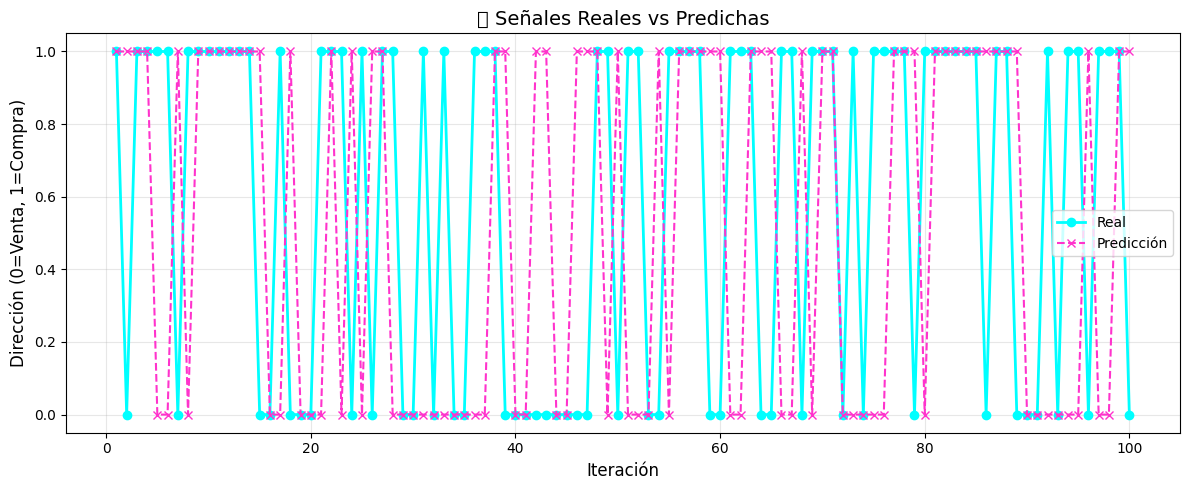

/tmp/ipykernel_805/1364624647.py:185: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/vscode/.local/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 129513 (\N{JIGSAW PUZZLE PIECE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


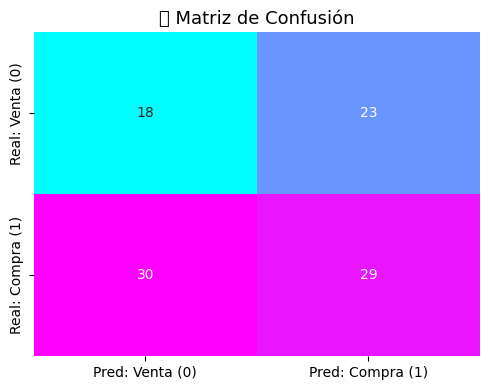

In [6]:
# ================================================================
# 🔥 MODELO RANDOM FOREST + INDICADORES + VISUALIZACIÓN AVANZADA
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ccxt
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

# ================================================================
# 📡 FUNCIÓN: DESCARGAR DATOS OHLCV DESDE BITGET
# ================================================================
def get_bitget_ohlcv(symbol="BTC/USDT", timeframe="1h", limit=1000):
    """
    Descarga datos OHLCV desde Bitget usando ccxt.
    Retorna un DataFrame con columnas: time, open, high, low, close, volume
    """
    try:
        exchange = ccxt.bitget()
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe=timeframe, limit=limit)
        df = pd.DataFrame(ohlcv, columns=["time", "open", "high", "low", "close", "volume"])
        df["time"] = pd.to_datetime(df["time"], unit="ms")
        return df
    except Exception as e:
        print("❌ Error al obtener datos de Bitget:", e)
        return pd.DataFrame()

# ================================================================
# 📊 FUNCIÓN: CREAR INDICADORES TÉCNICOS SIN PANDAS_TA
# ================================================================
def crear_features_modelo(df):
    """
    Calcula indicadores técnicos clásicos:
    RSI, medias móviles, bandas de Bollinger y cambio porcentual.
    """
    df = df.copy()

    # --- Medias móviles ---
    df["EMA_10"] = df["close"].ewm(span=10, adjust=False).mean()
    df["EMA_50"] = df["close"].ewm(span=50, adjust=False).mean()

    # --- RSI (fórmula manual) ---
    delta = df["close"].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    roll_up = up.rolling(14).mean()
    roll_down = down.rolling(14).mean()
    rs = roll_up / roll_down
    df["RSI"] = 100 - (100 / (1 + rs))

    # --- Bandas de Bollinger ---
    df["MA_20"] = df["close"].rolling(20).mean()
    df["STD_20"] = df["close"].rolling(20).std()
    df["Bollinger_Upper"] = df["MA_20"] + 2 * df["STD_20"]
    df["Bollinger_Lower"] = df["MA_20"] - 2 * df["STD_20"]

    # --- Cambio porcentual y dirección (target) ---
    df["pct_change"] = df["close"].pct_change()
    df["target"] = np.where(df["pct_change"].shift(-1) > 0, 1, 0)

    # Limpieza de NaN
    df = df.dropna().reset_index(drop=True)
    return df

# ================================================================
# 📈 DESCARGA Y PREPARACIÓN DE DATOS
# ================================================================
print("📡 Descargando datos desde Bitget...")
df = get_bitget_ohlcv("BTC/USDT", timeframe="1h", limit=1500)

if df.empty:
    raise ValueError("No se pudieron obtener datos desde Bitget.")

df = crear_features_modelo(df)
print("✅ Datos procesados:", df.shape)

# ================================================================
# 🔍 CONFIGURACIÓN DE ENTRENAMIENTO
# ================================================================
porcentaje_entreno = 0.8
n_iter = 100

tam_entreno = int(len(df) * porcentaje_entreno)
max_iter = len(df) - tam_entreno
if max_iter < 1:
    raise ValueError("Dataset demasiado pequeño para dividir entrenamiento y prueba.")

y_real_guardadas = []
y_pred_guardadas = []
relativ_error = []
corr_direccion = 0
iter_validas = 0

# ================================================================
# 🔁 ENTRENAMIENTO ITERATIVO
# ================================================================
for i in range(min(n_iter, max_iter)):
    inicio = i
    fin = tam_entreno + i

    df_train = df.iloc[inicio:fin]
    df_test = df.iloc[fin:fin+1]

    if df_train.empty or df_test.empty:
        print(f"Iteración {i+1}: slice vacío, se omite.")
        continue

    X_train = df_train[["EMA_10", "EMA_50", "RSI", "Bollinger_Upper", "Bollinger_Lower", "pct_change"]]
    y_train = df_train["target"]

    X_test = df_test[["EMA_10", "EMA_50", "RSI", "Bollinger_Upper", "Bollinger_Lower", "pct_change"]]
    y_test = df_test["target"].values

    modelo = RandomForestClassifier(n_estimators=100, random_state=42)
    modelo.fit(X_train, y_train)

    y_pred = modelo.predict(X_test)

    y_real_guardadas.extend(y_test)
    y_pred_guardadas.extend(y_pred)

    if y_pred[0] == y_test[0]:
        corr_direccion += 1

    relativ_error.append(abs(y_pred[0] - y_test[0]))
    iter_validas += 1

# ================================================================
# 📊 RESULTADOS FINALES
# ================================================================
if len(y_pred_guardadas) == 0:
    raise ValueError("No se generaron predicciones válidas.")

precision_direccion = corr_direccion / len(y_pred_guardadas)
error_relativo_promedio = np.mean(relativ_error)

print("\n" + "="*60)
print("📊  RESULTADOS DEL MODELO")
print("="*60)
print(f"✅ Iteraciones válidas: {iter_validas}")
print(f"🎯 Precisión de dirección: {precision_direccion:.2f}")
print(f"📉 Error relativo promedio: {error_relativo_promedio:.4f}")
print("="*60)

# ================================================================
# 📋 TABLA DE RESULTADOS
# ================================================================
resultados = pd.DataFrame({
    "Iteración": range(1, len(y_pred_guardadas)+1),
    "Real": y_real_guardadas,
    "Predicción": y_pred_guardadas
})

print("\n📋 Últimos 10 resultados:\n")
print(tabulate(resultados.tail(10), headers='keys', tablefmt='fancy_grid', showindex=False))

# ================================================================
# 📈 VISUALIZACIÓN DE PREDICCIONES
# ================================================================
plt.figure(figsize=(12,5))
plt.plot(resultados["Iteración"], resultados["Real"], label="Real", color="#00ffff", linewidth=2, marker='o')
plt.plot(resultados["Iteración"], resultados["Predicción"], label="Predicción", color="#ff33cc", linestyle="--", marker='x')
plt.title("📈 Señales Reales vs Predichas", fontsize=14)
plt.xlabel("Iteración", fontsize=12)
plt.ylabel("Dirección (0=Venta, 1=Compra)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# ================================================================
# 🧩 MATRIZ DE CONFUSIÓN
# ================================================================
matriz = confusion_matrix(resultados["Real"], resultados["Predicción"])
plt.figure(figsize=(5,4))
sns.heatmap(matriz, annot=True, fmt="d", cmap="cool", cbar=False,
            xticklabels=["Pred: Venta (0)", "Pred: Compra (1)"],
            yticklabels=["Real: Venta (0)", "Real: Compra (1)"])
plt.title("🧩 Matriz de Confusión", fontsize=13)
plt.tight_layout()
plt.show()



restricciones del 64%
'open_time', 'open', 'high', 'low', 'volume',
       'number_of_trades',  
       'pct_change_14d','Banda_Media', 
        'SMA_9', 'SMA_26', 'SMA_50', 'SMA_200', 'SMA', 'STD',
       'RSI_14',"direccion_pred"